In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
!pip install -Uqq tsai

     |████████████████████████████████| 170 kB 15.0 MB/s 
     |████████████████████████████████| 206 kB 78.6 MB/s 
     |████████████████████████████████| 28.5 MB 1.2 MB/s 
     |████████████████████████████████| 5.8 MB 32.0 MB/s 
     |████████████████████████████████| 188 kB 97.7 MB/s 
     |████████████████████████████████| 987 kB 70.9 MB/s 
     |████████████████████████████████| 72 kB 1.4 MB/s 
     |████████████████████████████████| 94 kB 4.9 MB/s 
     |████████████████████████████████| 22.3 MB 1.2 MB/s 
     |████████████████████████████████| 9.5 MB 59.3 MB/s 
     |████████████████████████████████| 2.5 MB 60.1 MB/s 
     |████████████████████████████████| 3.4 MB 81.2 MB/s 
     |████████████████████████████████| 118 kB 89.1 MB/s 
     |████████████████████████████████| 56 kB 5.3 MB/s 
     |████████████████████████████████| 25.3 MB 11.5 MB/s 
     |████████████████████████████████| 769 kB 72.1 MB/s 
     |████████████████████████████████| 1.1 MB 66.5 MB/s 
     |█████████████

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#from tsai.all import *
import math

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D

Extract the weights for the different participants in the correct format

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Bernard/timeseries/participant_info_simple.csv',nrows=984, delimiter = ",")
  #df = pd.read_csv(link, delimiter = "\t",skiprows=5,header=None)

In [4]:
import math
sub_mass=[]
sub=[]
mass=[]
for i in range(math.ceil(len(df['Mass'])/24)):
  sub_mass.append(np.array(df[['Subject','Mass']].iloc[i*24]))
sub_mass=np.insert(sub_mass,38, (39,66.35),0) 
  #sub.append(np.array(df['Subject'][i*24]))
  #mass.append(np.array(df['Mass'][i*24]))
#sub=np.insert(sub, 38, 1)   

Import files names

In [5]:
import glob
files1=sorted(glob.glob('/content/drive/MyDrive/Bernaed2/timeseries/s[0-9][0-9]_walkT[0-9][0-9]_S*.txt'))

files2=sorted(glob.glob('/content/drive/MyDrive/Bernaed2/timeseries/s[0-9][0-9]_walkT[0-9][0-9]_E*.txt'))


check if files from events and segment line up

In [ ]:
for i in range(len(files2)):
  if files1[i][43:54] != files2[i][43:54]:
    print(i)

Function that segments the data and pad zeroes

In [6]:
def segmenter4(link,link2):

  ### extract participant nbr to have his/her body mass
  sub_nbr=int(link[44:46])
  mass = sub_mass[sub_nbr-1][1]
  info=link[44:54]
  #print(sub_nbr,mass)
### Load file, drop timestamp and index column and 
### replace NAN with next value 
  df = pd.read_csv(link, delimiter = "\t",skiprows=5,header=None)
  
  df=df.fillna(method='backfill')
  df=df.fillna(method='ffill')
### Find indices of zeros in event store them in a and extract 
### the last zero to construct the windows and store in h

  df2 = pd.read_csv(link2, skiprows=[0,1,2,3],delimiter = "\t",usecols=['X'])
  df2 = df2.apply(lambda x: pd.Series(x.dropna().values))

  h=[]
  h.append([0])
  df2=np.array(df2)
  df2=df2.reshape(len(df2))
  for ron in df2[1:len(df2)]:
    h.append(df[df[1] ==ron].index.tolist())
  h = [x for x in h if x]




 
### store predictor in x, outcome in y event in z 

  x=[]
  y=[]
  z=[]
  inf=[]
  counter = 0
  cnt=[]

  # low_limit=110
  # high_limit=300
  
  # for i in range(len(h)-1):
    
    
  #   df_t =df[h[i][0]:h[i+1][0]]
    
    
      
  #   x.append(np.array(df_t.iloc[:,2:128]))
      
      
  #   y.append(np.array(df_t.iloc[:,131]))
  #   z.append(np.array(df_t.iloc[:,147]))
  #   inf.append(info)

  #   counter +=1
  #   cnt.append(counter)

  low_limit=110
  high_limit=300

  for i in range(len(h)-1):
    
    df_t =df[h[i][0]:h[i+1][0]]
   

    if len(df_t)> low_limit and len(df_t) < high_limit:
      npad = high_limit - len(df_t)
      x.append(np.pad(np.array(df_t.iloc[:,2:128]),((0,npad),(0,0)), mode='constant', constant_values=0))
      
      
      y.append(np.pad(np.array(df_t.iloc[:,131])/mass,(0,npad),mode='constant', constant_values=0))
      z.append(np.pad(np.array(df_t.iloc[:,147]),(0,npad),mode='constant', constant_values=0))
      inf.append(info)

      counter +=1
      cnt.append(counter)

  return x,y,z,inf,cnt

Run that function

In [7]:
from tqdm import tqdm
x=[]
y=[]
z=[]
inf=[]
cnt=[]
for i in tqdm(range(len(files1))):

  x_temp,y_temp,z_temp,inf_tmp,cnt_tmp =segmenter4(files1[i],files2[i]) 
  x +=x_temp
  y +=y_temp
  z +=z_temp
  inf +=inf_tmp
  cnt +=cnt_tmp


100%|██████████| 259/259 [00:45<00:00,  5.68it/s]


extract some features to remove noise

In [8]:
stat= np.zeros((len(x),3))
for i in range(len(x)):
  stat[i,0]= max(x[i][:,42])
  stat[i,1]=min(x[i][:,42])
  stat[i,2]=max(x[i][:,42])-min(x[i][:,42])
  # stat[i,3]=inf[i]
  # stat[i,4]=cnt[i]

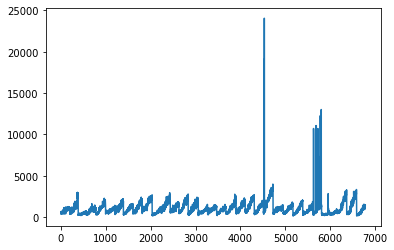

In [9]:
plt.plot(stat[:,0])

extract indices of the noisy segments

In [8]:
bad =[]
for i in range(len(stat)):
  if stat[i,0]> 4500:
    bad.append(i)


NameError: ignored

sort them in descending order

In [ ]:
bad2=sorted(bad, reverse=True)

delete them from X,Y, and other arrays

In [ ]:
for i in range(29):
  x = np.delete(x, bad2[i],axis =0)
  y = np.delete(y, bad2[i],axis =0)
  z = np.delete(z, bad2[i],axis =0)
  inf = np.delete(inf, bad2[i],axis =0)
  cnt = np.delete(cnt, bad2[i],axis =0)


compute area from outcome

In [ ]:
area = []
for i in range(len(y)):
  area.append(np.trapz(y[i]))
area=np.array(area).reshape(-1,1)
len(y),area.shape

Train test splits

In [ ]:
#X = np.moveaxis(np.array(x), -1, 1)
X = np.expand_dims(x, axis=3)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(area), test_size=0.25, random_state=42)
X_train.shape,y_train.shape,X_test.shape,y_train.shape

Regression models

In [24]:
model = Sequential()
#model.add(Dense(256, activation='relu', input_dim=366))
model.add(Conv2D(64, (3, 3), activation='relu', input_shape = X_train[0].shape))

model.add(Conv2D(128, (3, 3), activation='relu'))


model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(1, activation='linear'))


model.compile(loss='mean_squared_error', # one may use 'mean_absolute_error' as  mean_squared_error
                  optimizer='adam',
                  metrics=['mse', 'mae', 'mape'] # you can add several if needed
                 )

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 124, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 296, 122, 128)     73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 61, 128)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1155584)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               591659520 
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

In [25]:
model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_data=(X_test, y_test) )

Epoch 1/100
80/80 [==============================] - 24s 277ms/step - loss: 12135352.0331 - mse: 12135352.0331 - mae: 1146.2020 - mape: 8644.1649 - val_loss: 132.0343 - val_mse: 132.0343 - val_mae: 9.4088 - val_mape: 100.9842
Epoch 2/100
80/80 [==============================] - 21s 259ms/step - loss: 210.9195 - mse: 210.9195 - mae: 11.5685 - mape: 124.8867 - val_loss: 110.4935 - val_mse: 110.4935 - val_mae: 8.2398 - val_mape: 85.9680
Epoch 3/100
80/80 [==============================] - 21s 259ms/step - loss: 149.2086 - mse: 149.2086 - mae: 9.6603 - mape: 121.2656 - val_loss: 85.1014 - val_mse: 85.1014 - val_mae: 6.7589 - val_mape: 71.2993
Epoch 4/100
80/80 [==============================] - 21s 259ms/step - loss: 104.3268 - mse: 104.3268 - mae: 8.0157 - mape: 90.5200 - val_loss: 70.4336 - val_mse: 70.4336 - val_mae: 6.2632 - val_mape: 59.2579
Epoch 5/100
80/80 [==============================] - 21s 260ms/step - loss: 79.7561 - mse: 79.7561 - mae: 6.8548 - mape: 92.9545 - val_loss: 47.9

In [16]:
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

In [79]:
tfms  = [None, [TSRegression()]]

dls = get_ts_dls(X, y, splits=splits, tfms=tfms, bs=128)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=0.010964781977236271)

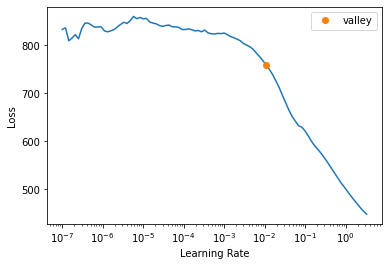

In [71]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,time
0,265.454071,8949.857422,86.843216,94.603683,00:01
1,104.488182,48.483295,5.528254,6.962995,00:01
2,54.784641,22.566431,3.649089,4.750413,00:01
3,30.896063,32.657314,4.934192,5.714658,00:01
4,21.789753,16.482574,3.269765,4.059874,00:01
5,15.882368,14.248824,3.003007,3.774761,00:01
6,12.211752,9.341934,2.320307,3.056458,00:01
7,9.394011,7.302898,2.028230,2.702388,00:01
8,7.419459,6.632759,1.929836,2.575414,00:01
9,6.219948,5.872514,1.802664,2.423327,00:01


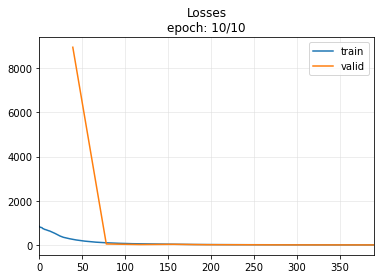

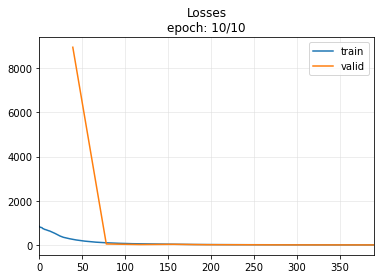

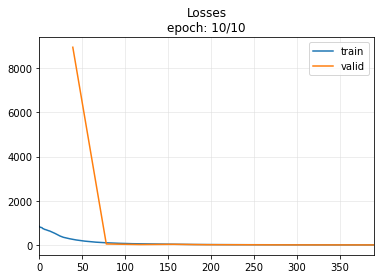

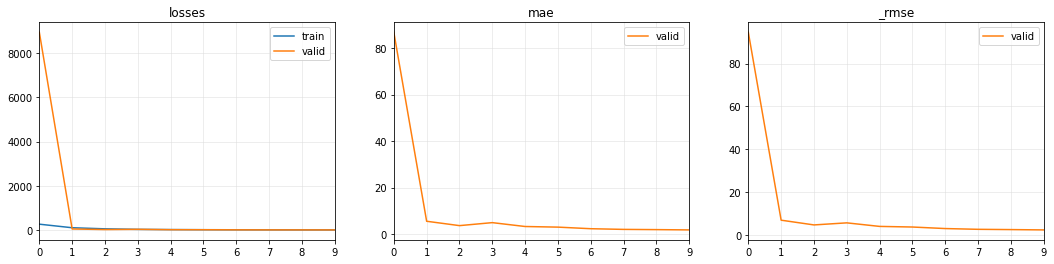

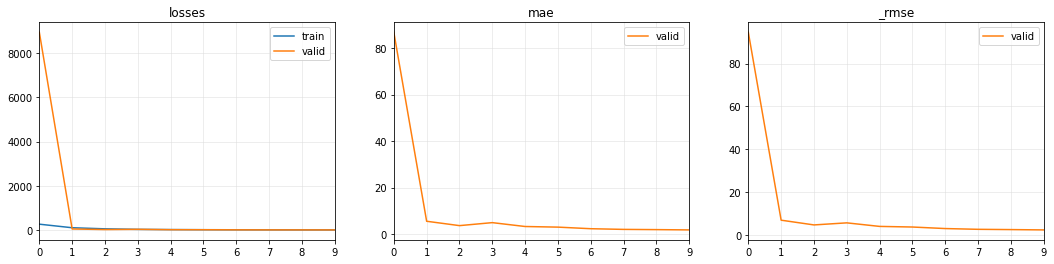

In [72]:
learn.fit_one_cycle(10, lr_max=slice(2e-3,1e-1), cbs=ShowGraph())

In [74]:
learn2 = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn2.unfreeze()

SuggestedLRs(valley=0.009120108559727669)

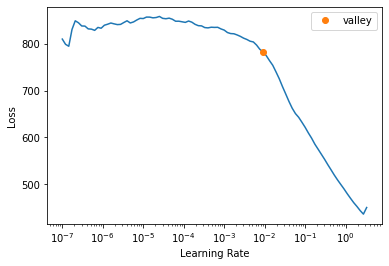

In [76]:
learn2.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,time
0,266.434662,3953.076416,58.542507,62.873501,00:01
1,109.551056,58.198528,5.634327,7.628796,00:01
2,60.832897,33.236347,4.345897,5.765097,00:01
3,36.756378,48.401848,5.833714,6.957144,00:01
4,22.703859,18.148436,3.555851,4.260098,00:01
5,17.217440,34.485340,5.007828,5.872422,00:01
6,13.043673,10.488065,2.548166,3.238528,00:01
7,11.576973,9.454464,2.374410,3.074811,00:01
8,8.647079,6.584536,1.922598,2.566035,00:01
9,7.616136,6.666626,1.914953,2.581981,00:01


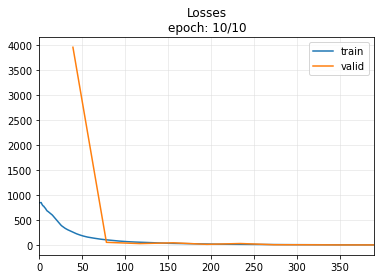

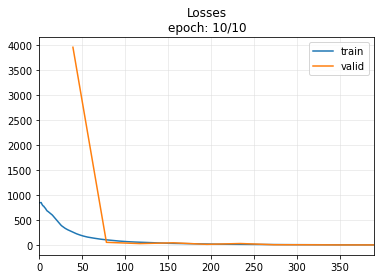

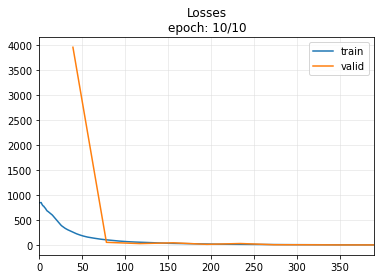

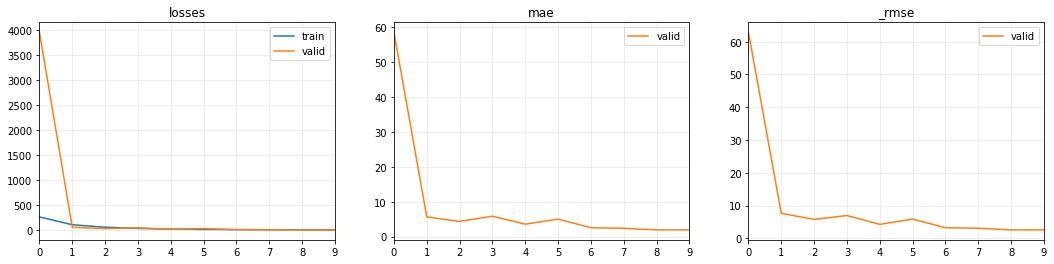

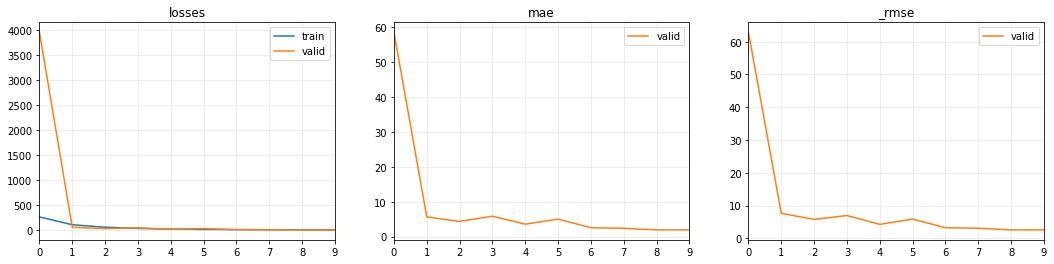

In [77]:
learn2.fit_one_cycle(10, lr_max=slice(2e-3,1e-1), cbs=ShowGraph())

SuggestedLRs(valley=0.05754399299621582)

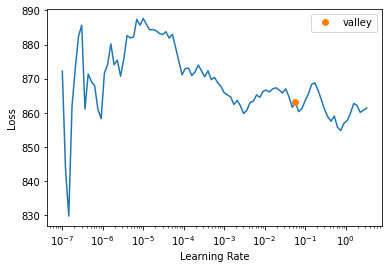

In [80]:
learn3 = ts_learner(dls, XceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn3.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,time
0,865.566162,877.629883,27.122196,29.624819,00:02
1,863.575500,870.959534,26.978783,29.512024,00:02
2,859.307312,869.324219,26.944597,29.484306,00:02
3,857.045654,868.733948,26.929924,29.474293,00:02
4,857.152100,868.704041,26.929228,29.473785,00:02
5,857.153320,868.699402,26.929090,29.473707,00:02
6,854.583801,868.699280,26.929085,29.473703,00:02
7,852.175903,868.699219,26.929085,29.473703,00:02
8,853.477722,868.699219,26.929085,29.473703,00:02
9,852.454834,868.699219,26.929085,29.473703,00:02


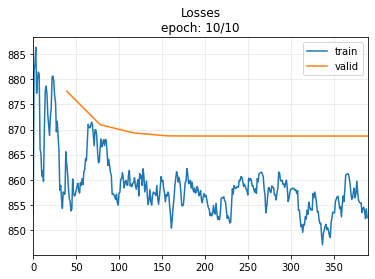

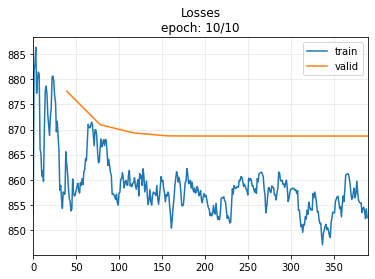

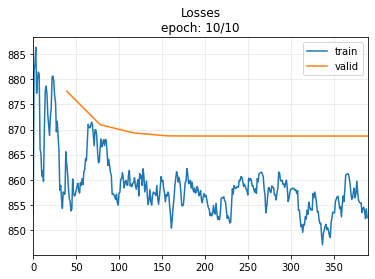

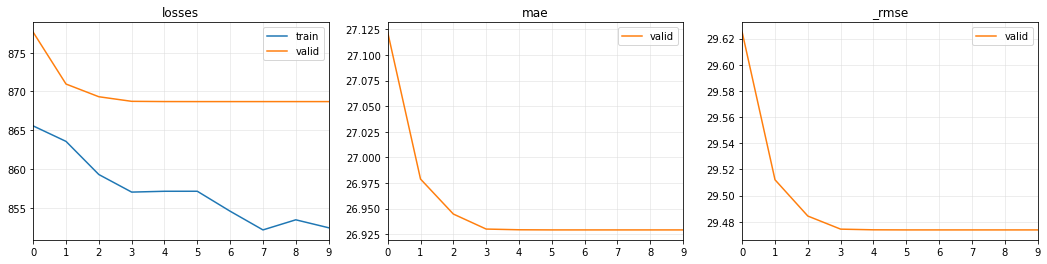

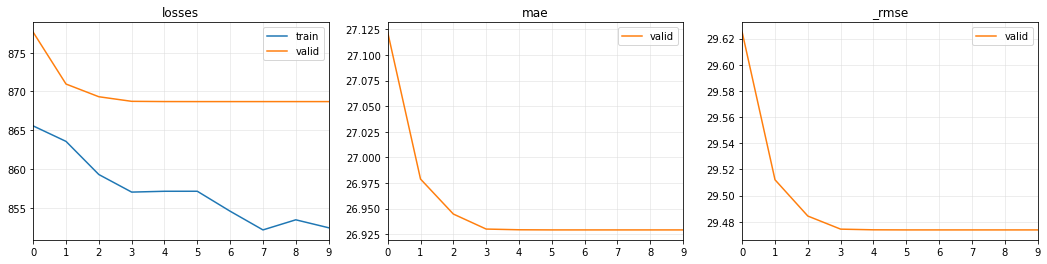

In [83]:
learn3.fit_one_cycle(10,  cbs=ShowGraph())

SuggestedLRs(valley=0.0063095735386013985)

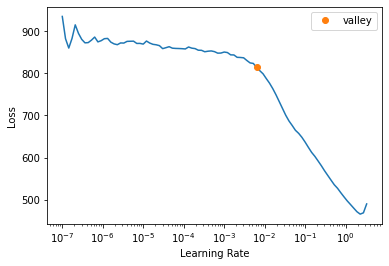

In [82]:
learn4 = ts_learner(dls, RNN_FCN, metrics=[mae, rmse], cbs=ShowGraph())
learn4.lr_find()


epoch,train_loss,valid_loss,mae,_rmse,time
0,276.824890,148.583786,10.480732,12.189494,00:01
1,113.992523,50.441498,5.533190,7.102218,00:01
2,58.441723,18.341413,3.422888,4.282688,00:01
3,34.460716,24.569965,4.035029,4.956810,00:01
4,23.079195,13.334453,2.816589,3.651637,00:01
5,17.186701,10.065614,2.446165,3.172635,00:01
6,13.477750,14.725760,3.139715,3.837416,00:01
7,10.553946,7.259022,2.040217,2.694257,00:01
8,8.190461,6.515413,1.906076,2.552531,00:01
9,6.909062,6.356509,1.875944,2.521212,00:01


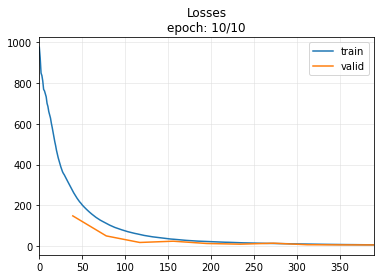

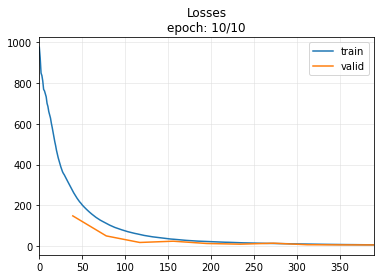

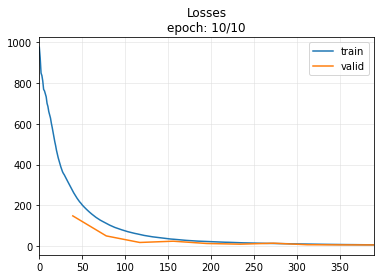

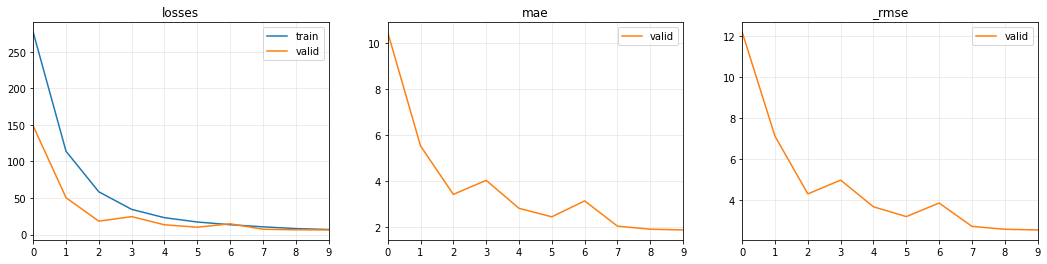

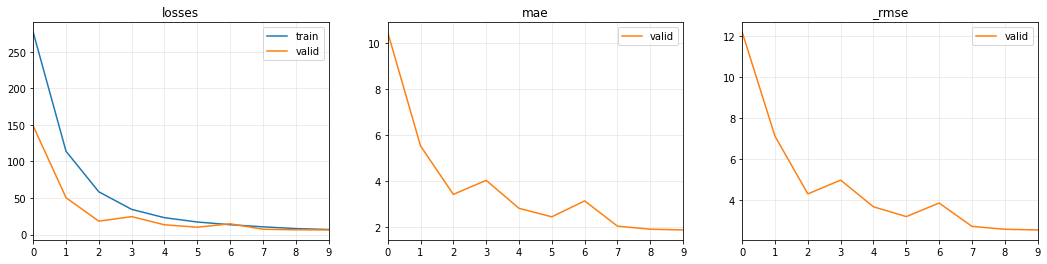

In [84]:
learn4.fit_one_cycle(10,  lr_max=slice(2e-3,1e-1), cbs=ShowGraph())

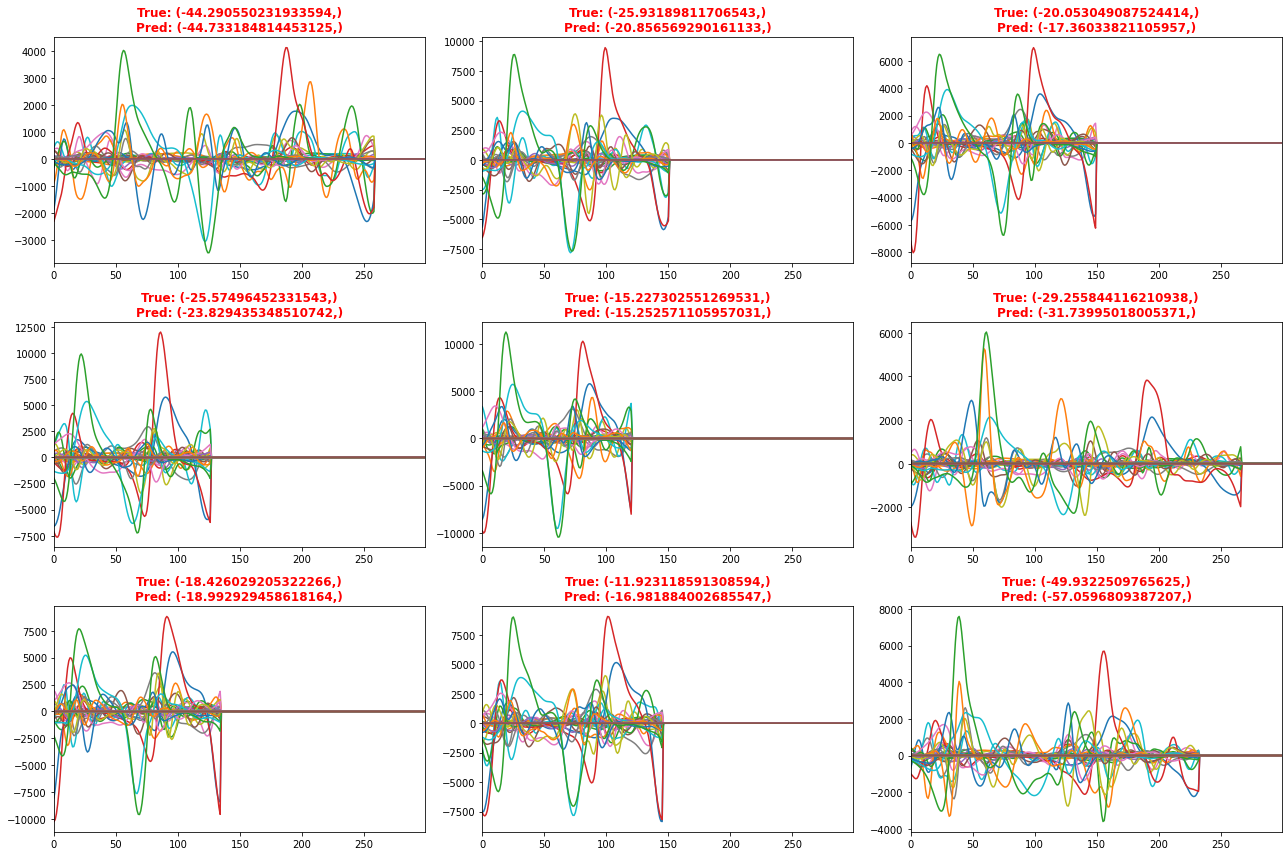

In [85]:
learn2.show_results(max_n=9)

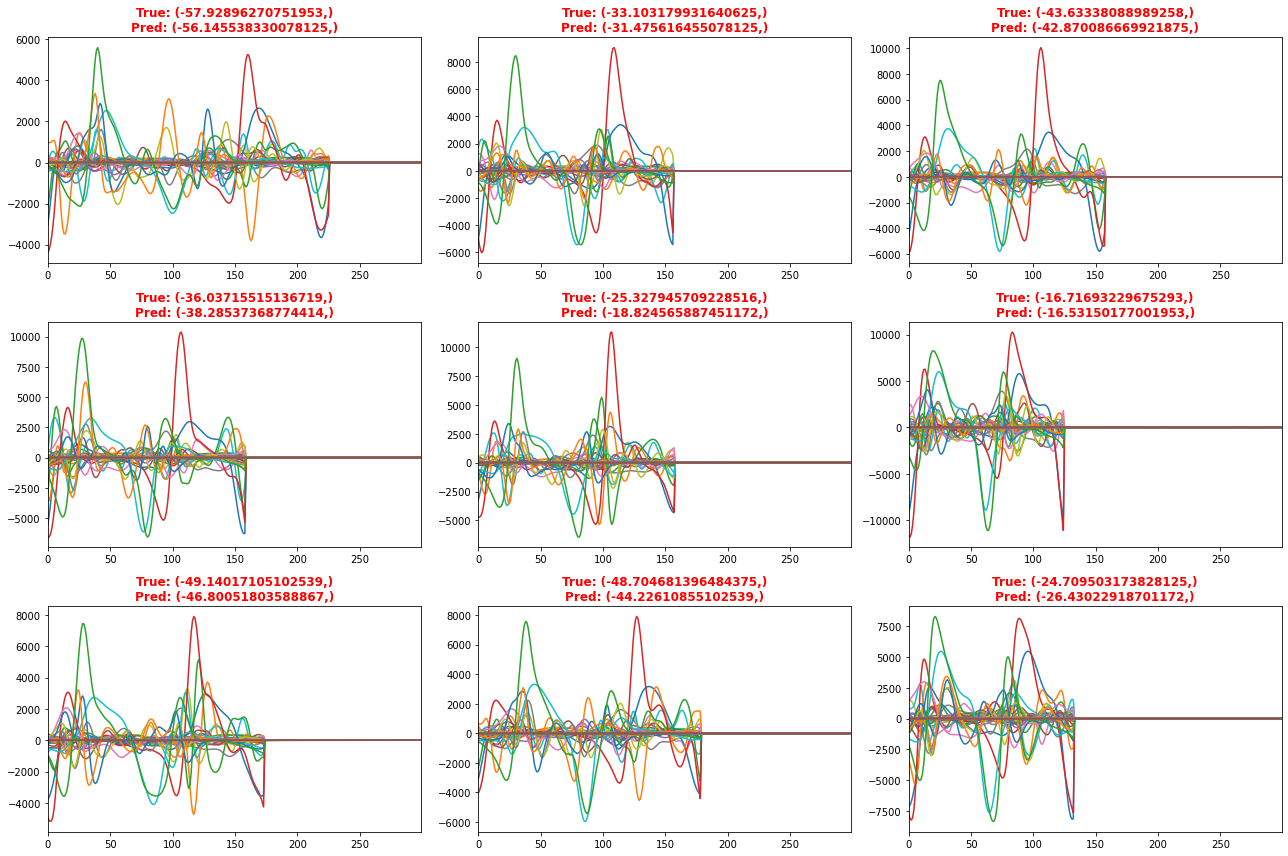

In [86]:
learn.show_results(max_n=9)

SuggestedLRs(valley=0.013182567432522774)

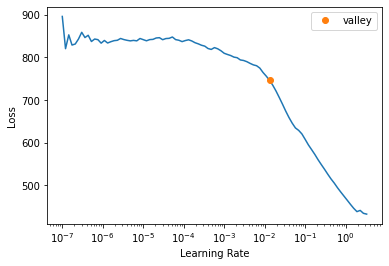

In [87]:
learn5 = ts_learner(dls, ResNet, metrics=[mae, rmse], cbs=ShowGraph())
learn5.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,time
0,250.859039,129664.218750,352.265564,360.089172,00:01
1,101.880966,24.131466,3.672203,4.912379,00:01
2,54.959129,925.551208,29.829651,30.422873,00:01
3,40.414108,43.233150,5.406991,6.575192,00:01
4,26.735437,17.272730,3.387812,4.156047,00:01
5,19.551733,25.334347,4.201291,5.033323,00:01
6,14.805902,10.532427,2.508230,3.245370,00:01
7,11.003292,8.090985,2.114734,2.844466,00:01
8,8.834072,7.134149,2.002507,2.670983,00:01
9,7.554875,6.849289,1.945028,2.617115,00:01


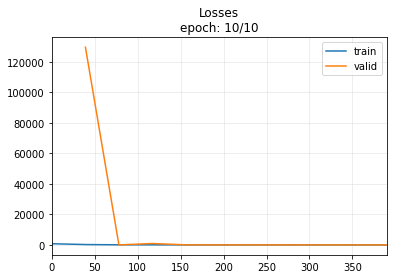

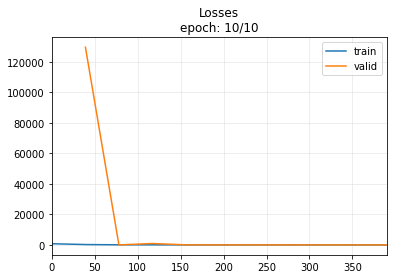

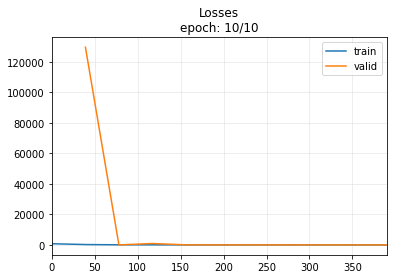

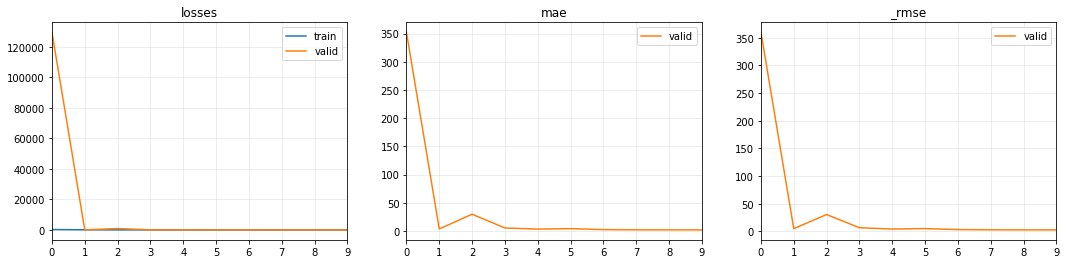

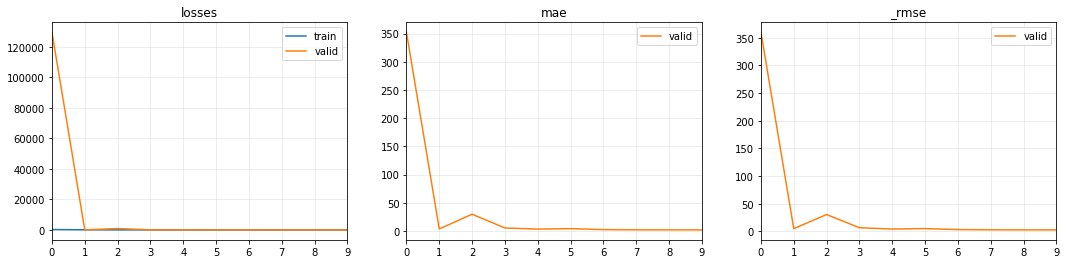

In [88]:
learn5.fit_one_cycle(10,  lr_max=slice(2e-3,1e-1), cbs=ShowGraph())

In [17]:
tfms  = [None, [TSRegression()]]
batch_tfms = [TSNormalize(),TSToGADF(300)]
dsets1 = TSDatasets(X, y, tfms=tfms, splits=splits)
dls1 = TSDataLoaders.from_dsets(dsets1.train, dsets1.valid, bs=[16,32], batch_tfms=batch_tfms)

In [19]:
model = create_model(xresnet18, dls=dls1)
learn6 = Learner(dls1, model,  metrics=[mae, rmse])

SuggestedLRs(valley=0.013182567432522774)

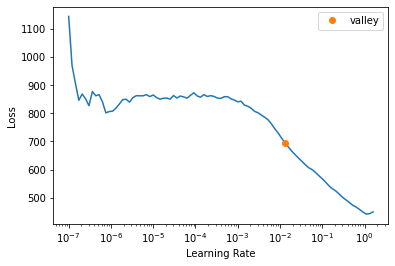

In [94]:
learn6.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,time
0,103.611076,2840.865723,52.202759,53.299767,11:49
1,103.903267,401.952820,16.428474,20.048761,11:57
2,82.050926,2456.399170,48.173042,49.562077,11:52
3,82.256485,147.539490,9.729872,12.146583,11:51
4,80.157272,441.966553,18.738230,21.023003,11:51
5,58.426655,13963.806641,117.563660,118.168556,11:48
6,60.640919,275.013184,12.897197,16.583523,11:47
7,40.182751,304.476318,13.736417,17.449251,11:47
8,29.157722,1522.475464,37.511246,39.018913,11:47
9,25.356667,19.625635,3.363300,4.430083,11:46


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


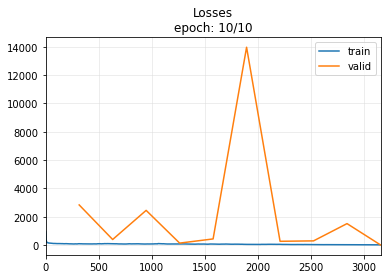

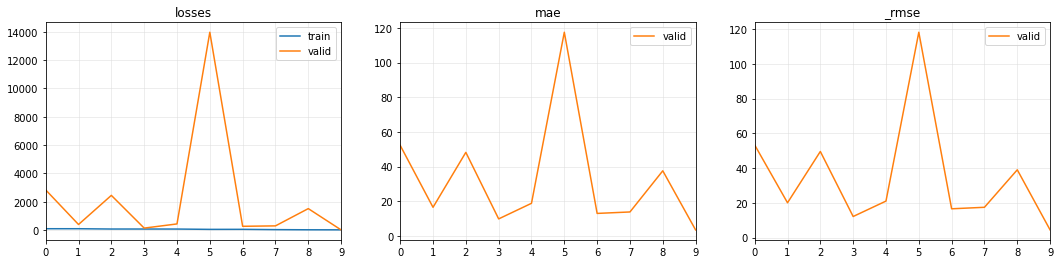

In [20]:
learn6.fit_one_cycle(10,  lr_max=slice(3e-3,8e-1), cbs=ShowGraph())